In [1]:
# import sys
# !{sys.executable} -m pip install nltk

In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import re

import sklearn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# scipy sparse matrix
import scipy
from scipy.sparse import hstack

import matplotlib.pyplot as plt

from string import digits

import os

## Data Preprocessing & Data Cleaning

We split up the URL into separate words, splitting by punctuation and similar chars.

In [3]:
def tokenize_and_lemmatize(s):
    s = s if s else ''
    try:
        tokens = filter(lambda x: x != '', re.split(r'\W', s))
        # http://www.hundreddogs-cats.com/something
        # http, www, hundreddogs, cats, com, something
        tokens = list(tokens)
    except Exception as e:
        tokens = []
        
    return ' '.join(tokens)


In [4]:
df = pd.read_csv('../../URL_Classification.csv', header=None)
df.columns = ["index", "url", "label"]

num_samples = len(df)
df = df[:num_samples]

df['url'] = df['url'].map(tokenize_and_lemmatize)

In [5]:
df.head(15)

,index,url,label
0,1,http www liquidgeneration com,Adult
1,2,http www onlineanime org,Adult
2,3,http www ceres dti ne jp nekoi senno senfirst ...,Adult
3,4,http www galeon com kmh,Adult
4,5,http www fanworkrecs com,Adult
5,6,http www animehouse com,Adult
6,7,http www2 117 ne jp mb1996ax enadc html,Adult
7,8,http archive rhps org fritters yui index html,Adult
8,9,http www freecartoonsex com,Adult
9,10,http www cutepet org,Adult


## Labeling

In [6]:
unique_labels = list(set(df['label']))
unique_labels.sort()

label2idx = {unique_labels[k] : k for k in range(len(unique_labels))}
idx2label = {i: k for k, i in label2idx.items()}

In [7]:
label2idx

{'Adult': 0,
 'Arts': 1,
 'Business': 2,
 'Computers': 3,
 'Games': 4,
 'Health': 5,
 'Home': 6,
 'Kids': 7,
 'News': 8,
 'Recreation': 9,
 'Reference': 10,
 'Science': 11,
 'Shopping': 12,
 'Society': 13,
 'Sports': 14}

In [8]:
df['label'] = df['label'].map(label2idx)

In [9]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(3, 3))

X = vectorizer.fit_transform(df['url'].apply(lambda x: np.str_(x)))
y = df['label'].values

# Shuffle data set, as it is still ordered at this point.
X, y = shuffle(X, y, random_state=67)

X.shape, y.shape

Training URL vectorizer...


((1562978, 3288899), (1562978,))

## SGDClassifier

In [10]:
clf = sklearn.linear_model.SGDClassifier(loss='hinge',
                                         class_weight='balanced',
                                         max_iter=1000,
                                         verbose=0,
                                         n_jobs=-1,
                                         n_iter_no_change=60,
                                         average=32)

### Split train/test set to evaluate result

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123456)

In [12]:
clf.fit(X_train, y_train)

SGDClassifier(average=32, class_weight='balanced', n_iter_no_change=60,
              n_jobs=-1)

In [13]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     24867
           1       0.98      0.95      0.97    177594
           2       1.00      0.97      0.98    168110
           3       0.97      0.96      0.97     82522
           4       0.89      0.96      0.92     39508
           5       0.94      0.97      0.95     42070
           6       0.84      0.98      0.90     19880
           7       0.77      0.85      0.80     32239
           8       0.58      0.99      0.73      6324
           9       0.98      0.96      0.97     74629
          10       0.80      0.91      0.86     40546
          11       0.92      0.91      0.92     77072
          12       0.99      0.98      0.98     66786
          13       0.99      0.93      0.96    170861
          14       0.97      0.97      0.97     71076

    accuracy                           0.95   1094084
   macro avg       0.90      0.95      0.92   1094084
weighted avg       0.96   

In [14]:
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.47      0.50     10458
           1       0.68      0.47      0.56     76246
           2       0.26      0.87      0.40     72067
           3       0.67      0.30      0.42     35440
           4       0.57      0.52      0.54     16969
           5       0.59      0.30      0.39     18027
           6       0.48      0.46      0.47      8389
           7       0.39      0.32      0.35     13943
           8       0.12      0.18      0.14      2665
           9       0.42      0.17      0.24     31957
          10       0.44      0.41      0.42     17701
          11       0.63      0.47      0.54     33214
          12       0.29      0.04      0.07     28484
          13       0.76      0.31      0.44     73082
          14       0.74      0.34      0.46     30252

    accuracy                           0.42    468894
   macro avg       0.50      0.38      0.40    468894
weighted avg       0.55   

normalize true / rows


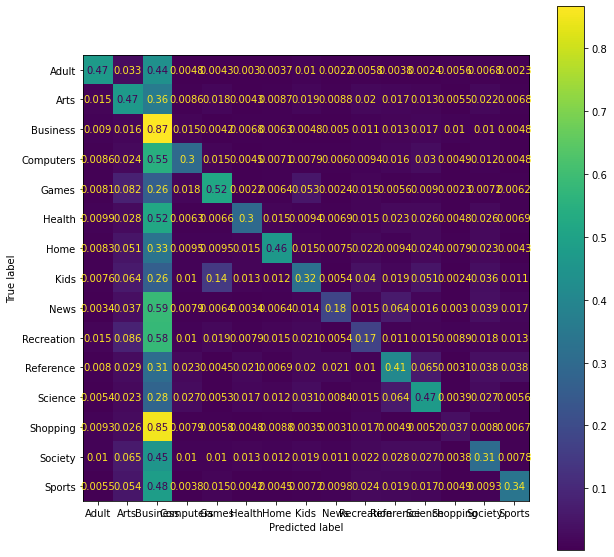

normalize pred / cols


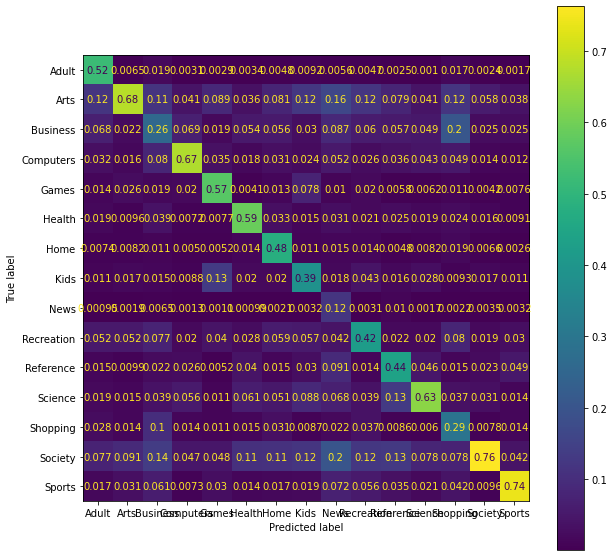

normalize all / cols + rows


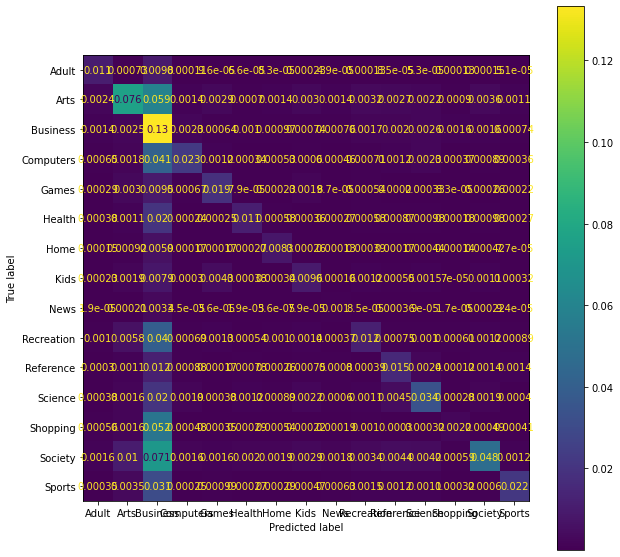

do not normalize


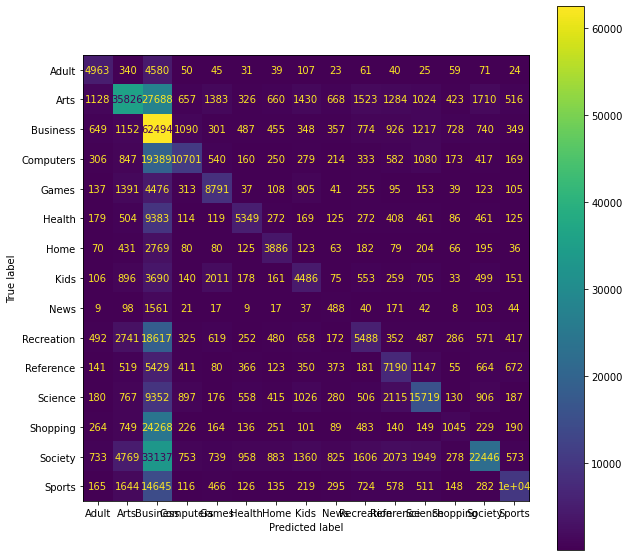

In [15]:
cm_true = confusion_matrix(y_test, y_pred, normalize='true', labels=[k for k in idx2label]) 
cm_pred = confusion_matrix(y_test, y_pred, normalize='pred', labels=[k for k in idx2label])
cm_all = confusion_matrix(y_test, y_pred, normalize='all', labels=[k for k in idx2label])
cm_none = confusion_matrix(y_test, y_pred, labels=[k for k in idx2label])


disp_true = ConfusionMatrixDisplay(confusion_matrix=cm_true, display_labels=unique_labels)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=cm_pred, display_labels=unique_labels)
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=unique_labels)
disp_none = ConfusionMatrixDisplay(confusion_matrix=cm_none, display_labels=unique_labels)

fig, ax = plt.subplots(figsize=(10, 10))
print('normalize true / rows')
disp_true.plot(include_values=True, ax=ax)
plt.show()

fig, bx = plt.subplots(figsize=(10, 10))
print('normalize pred / cols')
disp_pred.plot(include_values=True, ax=bx)
plt.show()

fig, cx = plt.subplots(figsize=(10, 10))
print('normalize all / cols + rows')
disp_all.plot(include_values=True, ax=cx)
plt.show()

fig, dx = plt.subplots(figsize=(10, 10))
print('do not normalize')
disp_none.plot(include_values=True, ax=dx)
plt.show()

In [16]:
cvs = cross_val_score(clf, X, y, cv=3, scoring='f1_macro')
print(f'Mean {np.mean(cvs):.5f} \tVar {np.var(cvs):.5f}')
print(cvs)

Mean 0.39779 	Var 0.00000
[0.39539256 0.39896003 0.39902003]
